# Описание данных

- Данные для первой части
      Файл /datasets/hypothesis.csv. 
      Hypothesis — краткое описание гипотезы;
      Reach — охват пользователей по 10-балльной шкале;
      Impact — влияние на пользователей по 10-балльной шкале;
      Confidence — уверенность в гипотезе по 10-балльной шкале;
      Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

- Данные для второй части
     
    Файл /datasets/orders.csv.
	  transactionId — идентификатор заказа;
	  visitorId — идентификатор пользователя, совершившего заказ;
	  date — дата, когда был совершён заказ;
	  revenue — выручка заказа;
	  group — группа A/B-теста, в которую попал заказ.

    Файл /datasets/visitors.csv.
	  date — дата;
	  group — группа A/B-теста;
	  visitors — количество пользователей в указанную дату в указанной группе A/B-теста


# План работы:

- Изучить файлы с данными.
- Проверить данные на пропуски, дубликаты.
- Провести предобработку данных.
- Провести приоритизацию гипотез (ICE, RICE)
- Проанализировать результаты А/В теста: построить графики, сформулировать гипотезы, посчитать стастические значимости
- Принять решение по результатам А/В теста

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np

import math
from scipy import stats

from datetime import timedelta
import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

In [2]:
hype = pd.read_csv('/datasets/hypothesis.csv')

orders = pd.read_csv('/datasets/orders.csv')
visits = pd.read_csv('/datasets/visitors.csv')

In [3]:
def check(data):
    data.info()
    nan_perc = data.isna().sum() / data.shape[0] * 100
    print()
    print('Индекс упорядочен:',data.index.is_monotonic)
    print('Кол-во дубликатов -',data.duplicated().sum())
    print()
    print('\033[1mКол-во пропусков:\033[0m')
    print(data.isna().sum())
    print()
    print('\033[1mПроцент пропусков:\033[0m')
    print(nan_perc.sort_values(ascending=False))
    print('---------------------------')
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])

In [5]:
def bar(data, column, title):
    plt.suptitle(title, fontsize = "xx-large")
    data[column].value_counts().plot(kind='bar',grid=True,figsize=(10,5))

### Данные о гипотезах

In [6]:
hype.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [7]:
check(hype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Процент пропусков:
Hypothesis    0.0
Reach         0.0
Impact        0.0
Confidence    0.0
Efforts       0.0
dtype: float64
---------------------------

Cтолбец Hypothesis
Кол-во уникальных значений - 9
Кол-во пропусков - 0
Кол-во дубликатов - 0

Запустить акцию, дающую скидку на товар в день рождения                                                 1
Добавить форму подписки на все основные страницы, чт

**Промежуточный вывод:**
- Пропуски и дубликаты отсутствуют. 
- Данные не нуждаются в предобратке и готовы к анализу.

### Данные с A/B тестом

#### Orders

In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
check(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Процент пропусков:
transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64
---------------------------

Cтолбец transactionId
Кол-во уникальных значений - 1197
Кол-во пропусков - 0
Кол-во дубликатов - 0

1658608862    1
2211880073    1
3913205113    1
437656952     1
3592105335    1
Name: transactionId

**Промежуточные выводы:**
- Пропуски дубликаты отсутствуют.
- Заменить тип данных столбца date. 
- Переименовать столбцы: transactionId, visitorId на orderId, userId.

#### Visits

In [10]:
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
check(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Индекс упорядочен: True
Кол-во дубликатов - 0

Кол-во пропусков:
date        0
group       0
visitors    0
dtype: int64

Процент пропусков:
date        0.0
group       0.0
visitors    0.0
dtype: float64
---------------------------

Cтолбец date
Кол-во уникальных значений - 31
Кол-во пропусков - 0
Кол-во дубликатов - 31

2019-08-15    2
2019-08-31    2
2019-08-01    2
2019-08-08    2
2019-08-04    2
Name: date, dtype: int64


Cтолбец group
Кол-во уникальных значений - 2
Кол-во пропусков - 0
Кол-во дубликатов - 60

B    31
A    31
Name: group, dtype: int64


Cтолбец visitors
Кол-во уникальных значений - 58
Кол-во пропусков - 0
Кол-во дубликатов - 4

6

**Промежуточные выводы:**
- Пропуски дубликаты отсутствуют.
- Заменить тип данных столбца date. 

### Подготовка данных

In [12]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visits['date'] = visits['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [13]:
orders = orders.rename(columns = {'transactionId':'orderId', 'visitorId':'userId'})

In [14]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1197 non-null   int64         
 1   userId   1197 non-null   int64         
 2   date     1197 non-null   datetime64[ns]
 3   revenue  1197 non-null   int64         
 4   group    1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [16]:
print('Orders | Минимальная дата: {}, Максимальная дата: {}'.format(orders['date'].min(), orders['date'].max()))
print('Visits | Минимальная дата: {}, Максимальная дата: {}'.format(visits['date'].min(), visits['date'].max()))

Orders | Минимальная дата: 2019-08-01 00:00:00, Максимальная дата: 2019-08-31 00:00:00
Visits | Минимальная дата: 2019-08-01 00:00:00, Максимальная дата: 2019-08-31 00:00:00


### Выводы

Мы получили три таблицы с данными, в которых отсутствовали пропуски и дубликаты.
Для решения поставленной задачи, в данных о заказах и визитах на сайт, заменили тип данных столбцов date и переименовали столбцы для удобства.
Даты исследуемого периода: 2019-08-01 по 2019-08-31.

In [17]:
users_AB = orders.pivot_table(index='userId', values='group', aggfunc='nunique')
users_AB.reset_index()

users_AB.query('group > 1').count()

group    58
dtype: int64

58 пользователей оказались в обоих группах А и В. Предпологаю, что их присутвие никак не скажется, на дальнешем исследовании.

## Часть 1. Приоритизация гипотез.

In [18]:
hype['ICE'] = (hype['Impact']*hype['Confidence']) / hype['Efforts']
hype['RICE'] = (hype['Reach']*hype['Impact']*hype['Confidence']) / hype['Efforts']

### ICE для приоритизации гипотез.

In [19]:
hype.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


### RICE для приоритизации гипотез.

In [20]:
hype.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000,3.0


### Вывод

Видим, как параметр Reach (охват) меняет приоритетность. Фреймворк RICE меняет тройку лидеров. Неизменным остались позиции гипотез 6 и 4. Предложить для теста гипотезу № 7. 

## Часть 2. Анализ A/B-теста

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [21]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [22]:
# кумулятивные данные из orders
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                    orders['group'] == x['group']
        )
    ].agg(
        {'date': 'max','group': 'max','orderId': pd.Series.nunique,
        'userId': pd.Series.nunique,'revenue': 'sum',}
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# кумулятивные показатели из visits
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

#объединяем данные
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date',   'group', 'orders', 'buyers', 'revenue', 'visitors',]

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B']

In [23]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


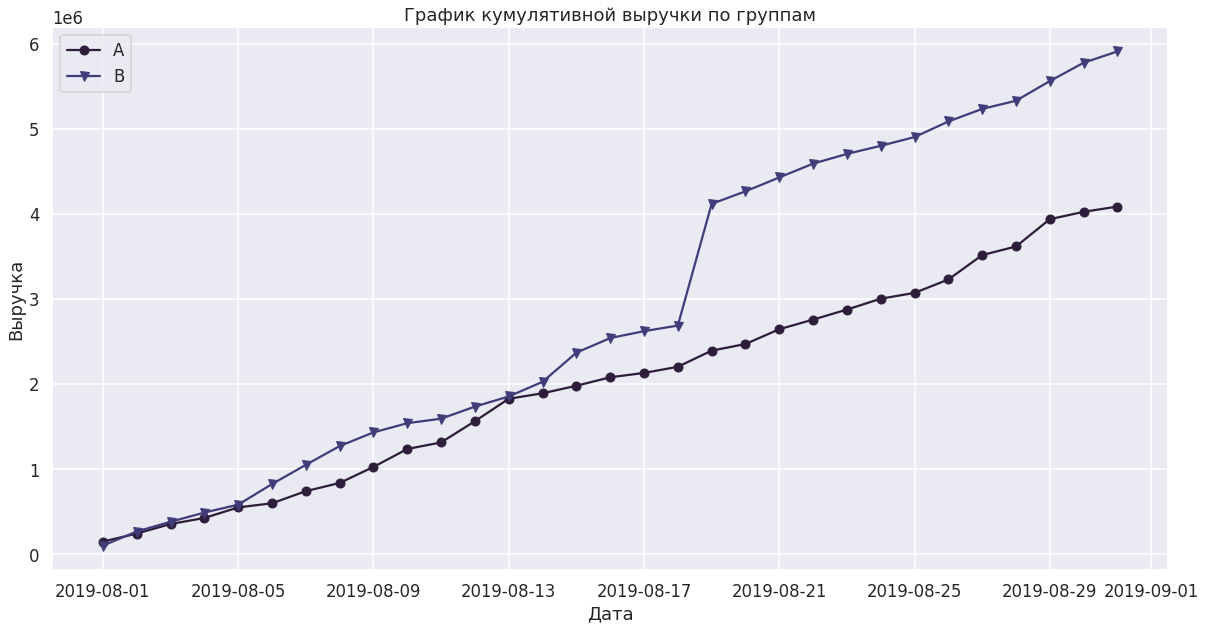

In [24]:
plt.figure(figsize=(20,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A', marker='o')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B', marker='v')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.show()

**Вывод:** Видим, что выручка в группе «В» с самого начала выше, чем в группе «А». Также, имеется сильный скачок по выручке в группе «В» после 17 августа, возможно, это связано с крупными заказами или на эти даты пришлось большое кол-во заказов.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

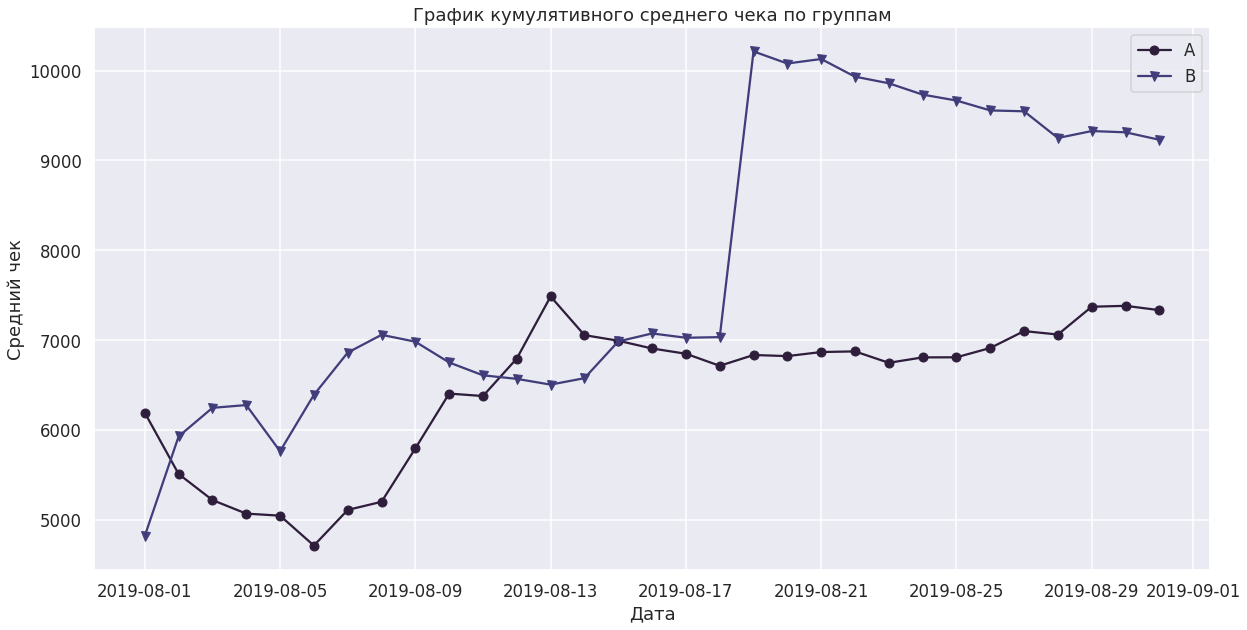

In [25]:
plt.figure(figsize=(20,10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/ cumulativeRevenueA['orders'], label='A', marker='o')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B', marker='v')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show()

**Вывод:** Видим, схожесть с предыдущим графиком. Здесь видим даты вначале исследуемого периода, когда средний чек группа «А»  больше «В». Скачек группы «В» выглядит аномальным. Далее видим, как с 21 августа идет постоянное снижение в группе «В».

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

In [26]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


In [27]:
mergedCumulativeRevenue.head()

,date,groupA,ordersA,buyersA,revenueA,visitorsA,groupB,ordersB,buyersB,revenueB,visitorsB
0,2019-08-01,A,24,20,148579,719,B,21,20,101217,713
1,2019-08-02,A,44,38,242401,1338,B,45,43,266748,1294
2,2019-08-03,A,68,62,354874,1845,B,61,59,380996,1803
3,2019-08-04,A,84,77,425699,2562,B,78,75,489567,2573
4,2019-08-05,A,109,100,549917,3318,B,101,98,581995,3280


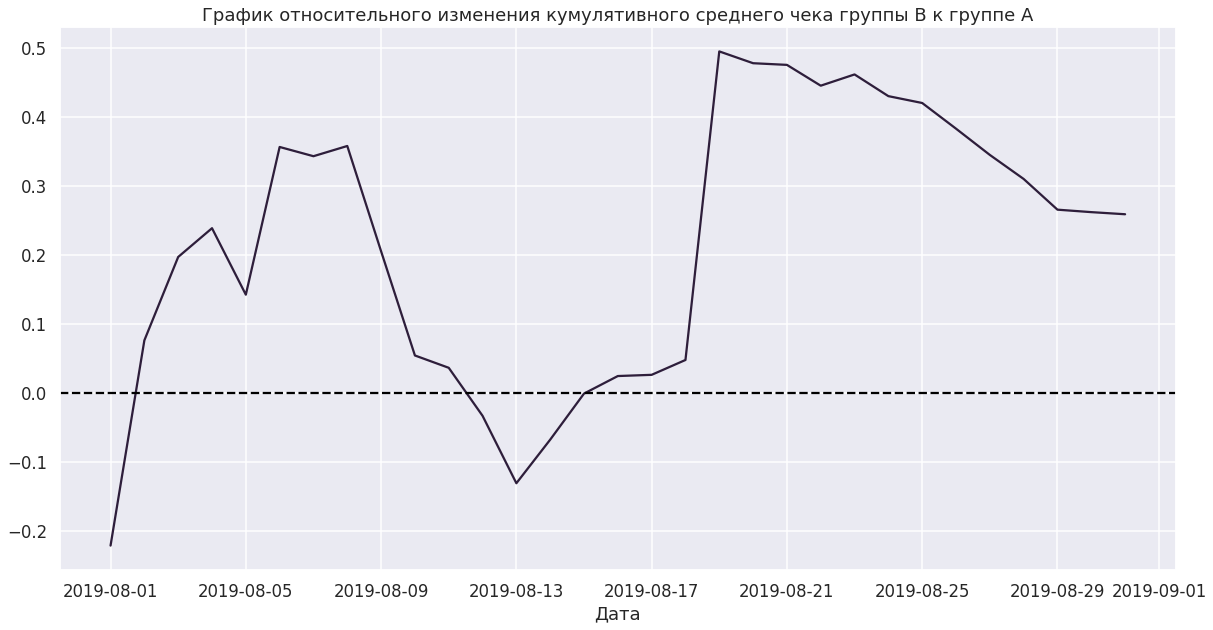

In [28]:
plt.figure(figsize=(20,10))
plt.plot(mergedCumulativeRevenue['date'],(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle= '--')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

**Вывод:** Видим, что результаты теста имеют резкие колебания. Скорей всего, в промежутках резки скачков были совершены аномальные заказы.

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

In [29]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeConversionA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeConversionB = cumulativeData[cumulativeData['group'] == 'B']

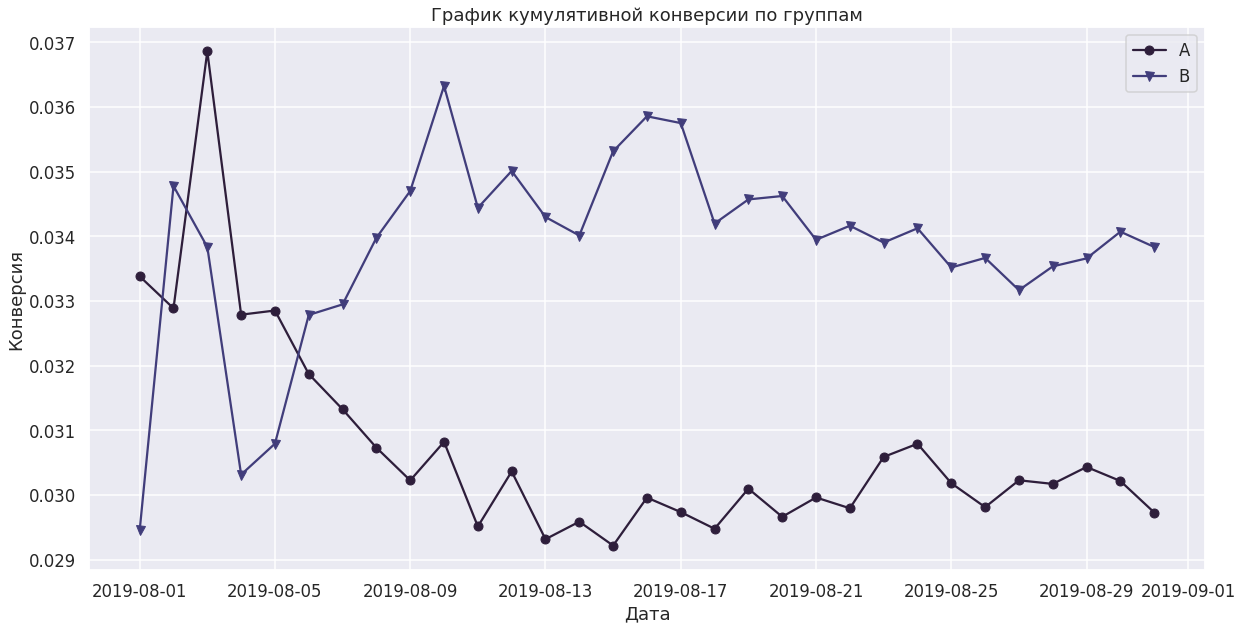

In [30]:
plt.figure(figsize=(20,10))
plt.plot(cumulativeConversionA['date'], cumulativeConversionA['conversion'], label='A', marker='o')
plt.plot(cumulativeConversionB['date'], cumulativeConversionB['conversion'], label='B', marker='v')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
plt.show()

**Вывод:** Видим, как с 1 по 5 число конверсия группы «А» больше. Группа «В» с 6 августа стабильно показывает большую конверсию. После 17 августа примерная конверсия группы «В» в районе 0.034, а группы «А» 0.030.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

In [31]:
mergedCumulativeConversions = cumulativeConversionA[
    ['date','conversion']].merge(cumulativeConversionB[
    ['date','conversion']], left_on='date', right_on='date', 
                                 how='left', suffixes=['A', 'B'])

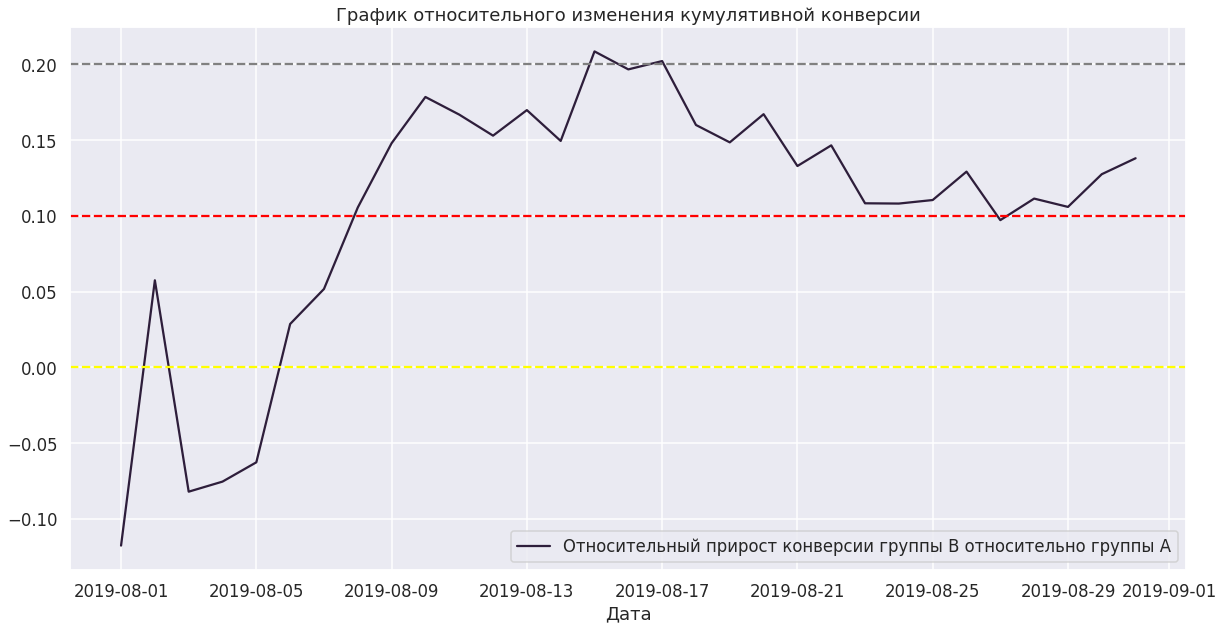

In [32]:
plt.figure(figsize=(20,10))
plt.title('График относительного изменения кумулятивной конверсии')
plt.xlabel('Дата')
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/ 
         mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='yellow', linestyle='--')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.legend()
plt.show()

**Вывод:** Видим, что после 8 августа по окончание исследуемого периода прирост конверсии группы «В» не опускался ниже 10%, а с 14 августа по 17 августа был на уровне 20%.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [33]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique}))

ordersByUsers.columns = ['userId', 'orders']

In [34]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head())

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


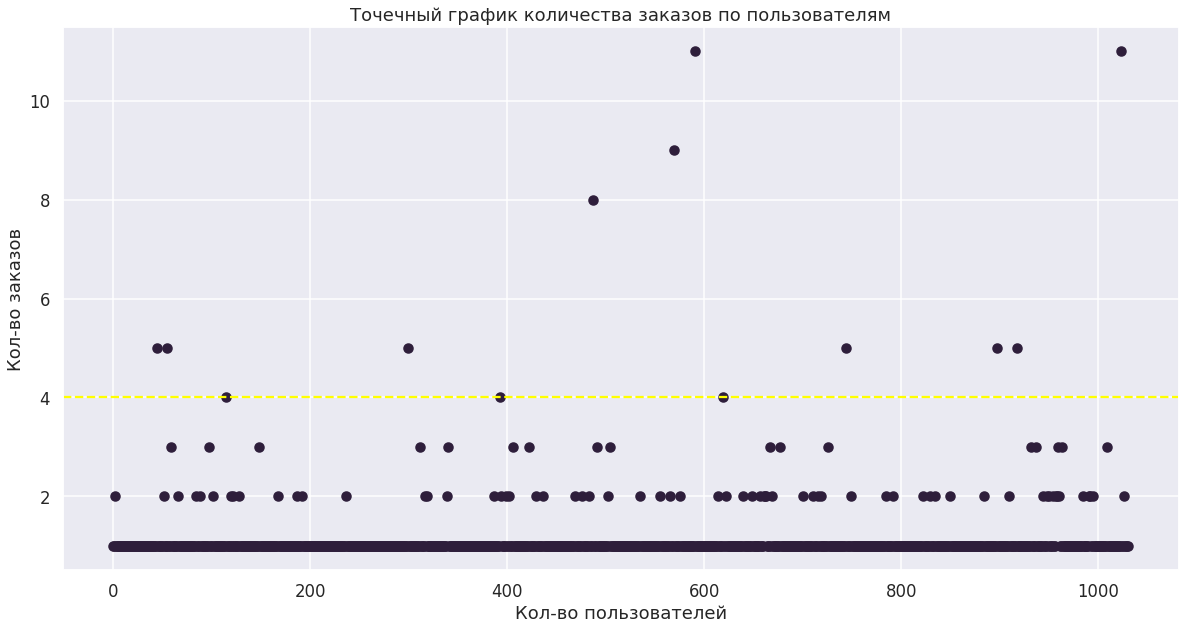

In [35]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(20,10))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Кол-во пользователей')
plt.ylabel('Кол-во заказов')
plt.axhline(y=4, color='yellow', linestyle='--')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

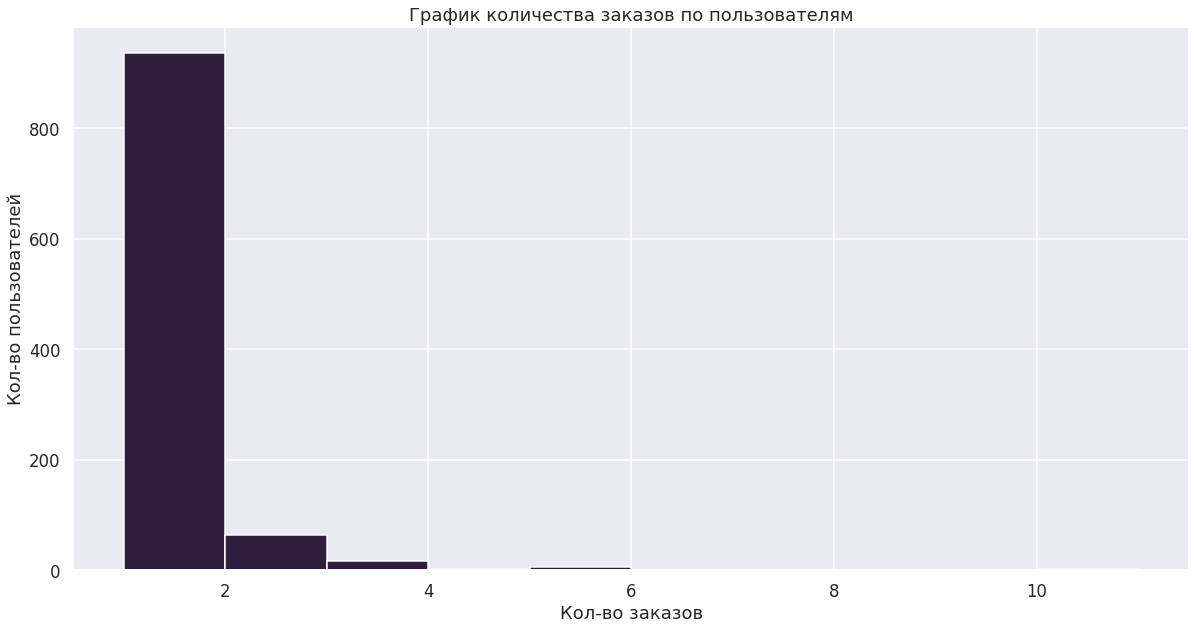

In [36]:
plt.figure(figsize=(20,10))
plt.title('График количества заказов по пользователям')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Кол-во заказов')
plt.hist(ordersByUsers['orders'])
plt.show()

**Вывод:** Большинство совершили 1 заказ. Видим, что по 2 заказа уже значительно меньше.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [37]:
print(np.percentile(ordersByUsers['orders'],[95,99]))

[2. 4.]


In [38]:
print(np.percentile(ordersByUsers['orders'],[96,97,98]))

[2. 2. 3.]


**Вывод:** Видим, что не больше 3% пользователей совершают больше двух заказов и не более 1% —  больше 4-х. Установим 2 заказа, как границу аномалий.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

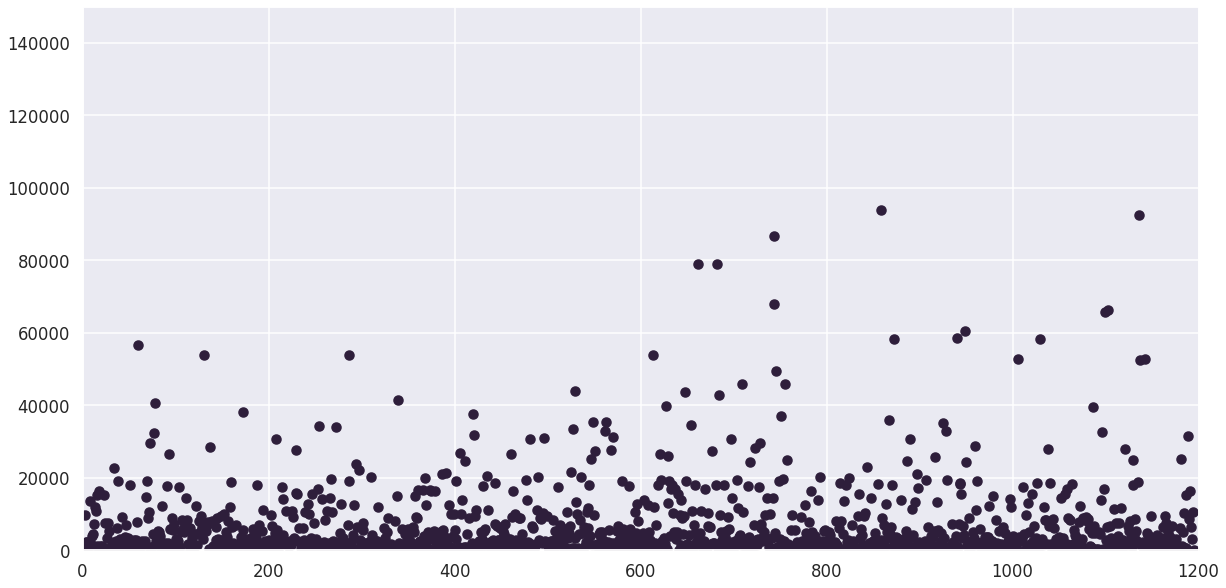

In [39]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(20,10))
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 150000])
plt.show()

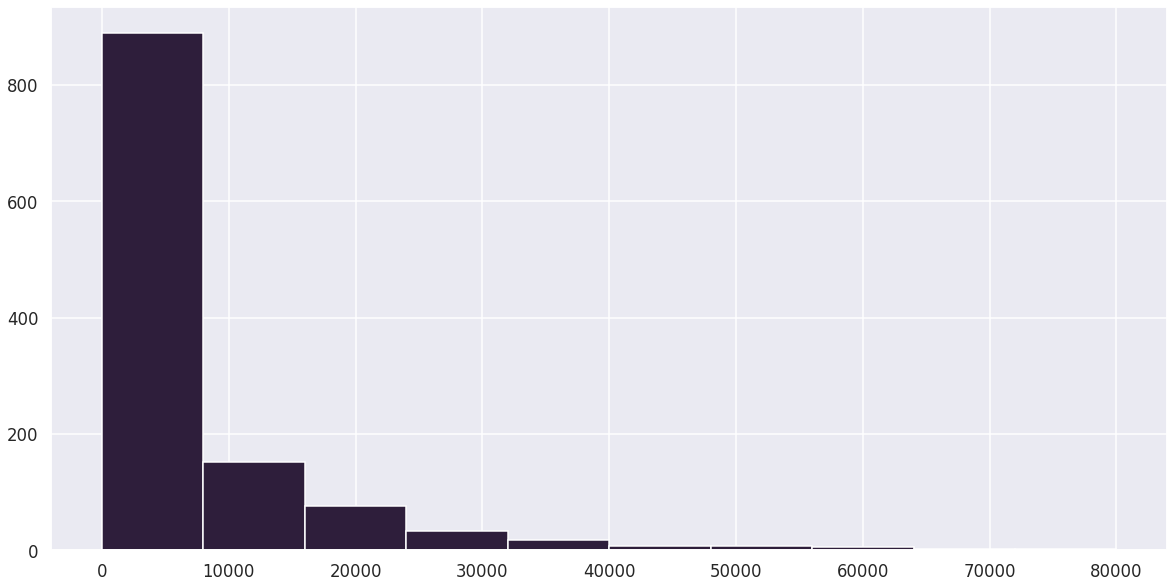

In [40]:
plt.figure(figsize=(20,10))
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.hist(orders['revenue'], range=(0, 80000))
plt.show()

**Вывод:** Видим, что большинство покупок приходится на сумму до 30 тыс.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [41]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


In [42]:
print(np.percentile(orders['revenue'],[96,97,98]))

[31382.  35485.  44133.2]


**Вывод:** Видим, что всего лишь 5% покупок дороже 28 тыс. Только 1% от 58 тыс. Установим 28 тыс., как границу аномалий.

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

- Так, как у нас независимые выборки применим статистический метод  — критерий Манна-Уитни, который позволит проверять гипотезы о совпадении распределений в выборках.
- Подготовим данные и софрмулируем гипотезу.

In [43]:
visitorsADaily = visits[visits['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visits[visits['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]. \
                                            agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


ordersADaily = orders[orders['group']=='A'][['date', 'orderId', 'userId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'orderId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'orderId', 'userId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'orderId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [44]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
data.head(3)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803


In [45]:
ordersByUsersA = (
orders[orders['group'] == 'A'].groupby('userId', as_index=False)
.agg({'orderId': pd.Series.nunique}))

ordersByUsersA.columns = ['userId','orders']

ordersByUsersB = (
orders[orders['group'] == 'B'].groupby('userId', as_index=False)
.agg({'orderId': pd.Series.nunique}))

ordersByUsersB.columns = ['userId','orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

**Гипотеза**

Нулевая гипотеза H₀: «Различий в конверсии между группами по «сырым» данным — нет!»

Альтернативная гипотеза H₁: "Различий в конверсии между группами по «сырым» данным — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и конверсия между группами по «сырым» данным равна».

In [46]:
print('Относительный прирост конверсии группы B к группе A: {:.3f}'.format(
    sampleB.mean()/sampleA.mean()-1))
print()

alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')

print('P-value: {:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами конверсия разная')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу, между группами конверсия равна!')
    print('Статистической значимости — нет!')

Относительный прирост конверсии группы B к группе A: 0.138

P-value: 0.017
Отвергаем нулевую гипотезу: между группами конверсия разная
Статистическая значимость — есть!


### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

**Гипотеза**

Нулевая гипотеза H₀: «Различий в среднем чеке между группами по «сырым» данным — нет!»

Альтернативная гипотеза H₁: "Различия в среднем чеке между группами по «сырым» данным — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и средние чеки между группами по «сырым» данным равны».

In [47]:
orders_sample_A = orders[orders['group']=='A']['revenue']
orders_sample_B = orders[orders['group']=='B']['revenue']

In [48]:
print('Относительное изменение среднего чека в группе B к группе A: {:.3f}'.format(
orders_sample_B.mean()/orders_sample_A.mean()-1))

print()
results = stats.mannwhitneyu(orders_sample_A, orders_sample_B, alternative = 'two-sided')
print('P-value: {:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами средние чеки разные')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между группами средний чек равный!')
    print('Статистической значимости — нет!')

Относительное изменение среднего чека в группе B к группе A: 0.259

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу: между группами средний чек равный!
Статистической значимости — нет!


### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

In [49]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],axis=0,)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['userId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
)

print('Аномалий:',len(abnormalUsers))

Аномалий: 74


In [50]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),name='orders')],axis=0) 

print('sampleAFiltered:',len(sampleAFiltered))
print('sampleBFiltered:',len(sampleBFiltered))

sampleAFiltered: 18690
sampleBFiltered: 18869


**Гипотеза**

Нулевая гипотеза H₀: «Различий в конверсии между группами по «очищенным» данным — нет!»

Альтернативная гипотеза H₁: "Различий в конверсии между группами по «очищенным» данным — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и конверсия между группами по «очищенными» данным равна».

In [51]:
print('Относительное изменение конверсии в группе B к группе A: {:.3f}'.format(
sampleBFiltered.mean()/sampleAFiltered.mean()-1))
print()
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')
print('P-value: {:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами конверсия разная')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу, между группами конверсия равна!')
    print('Статистической значимости — нет!')

Относительное изменение конверсии в группе B к группе A: 0.173

P-value: 0.013
Отвергаем нулевую гипотезу: между группами конверсия разная
Статистическая значимость — есть!


### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

**Гипотеза**

Нулевая гипотеза H₀: «Различий в среднем чеке между группами по «очищенным» данным — нет!»

Альтернативная гипотеза H₁: "Различия в среднем чеке между группами по «очищенным» данным — есть!».

При получении ответа "Отвергаем нулевую гипотезу» это будет означать, что данные различаются и скорей всего наше предположение неверно.

При получении ответа "Не получилось отвергнуть нулевую гипотезу", это означать что предположение верно и средние чеки между группами по «очищенным» данным равны».

In [52]:
sampleA_revenue = orders[np.logical_and(orders['group']=='A', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue']
sampleB_revenue = orders[np.logical_and(orders['group']=='B', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue']

In [53]:
print('Относительное изменение среднего чека в группе B к группе A: {:.3f}'.format(
sampleA_revenue.mean()/sampleB_revenue.mean()-1))
print()
results = stats.mannwhitneyu(sampleA_revenue, sampleB_revenue, alternative = 'two-sided')
print('P-value: {:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: между группами средние чеки разные')
    print('Статистическая значимость — есть!')
else:
    print('Не получилось отвергнуть нулевую гипотезу: между группами средний чек равный!')
    print('Статистической значимости — нет!')

Относительное изменение среднего чека в группе B к группе A: 0.020

P-value: 0.738
Не получилось отвергнуть нулевую гипотезу: между группами средний чек равный!
Статистической значимости — нет!


### Вывод

- Есть статистическая значимость различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;
- После очистки данных прирост конверсии примерно 17% в пользу В.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий

### Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Исходя из обнаруженных фактов группа В победила, не смотря на то, что статистически значимого различия по среднему чеку между группами не удалось найти. Тест следует остановить и признать его успешным, и перейти к проверке следующей гипотезы под номером 7 (из первой части проекта).